<a href="https://colab.research.google.com/github/albertofernandezvillan/computer-vision-and-deep-learning-course/blob/main/inpaint_algorithm_in_opencv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" style="padding-right:10px;" src ="https://raw.githubusercontent.com/albertofernandezvillan/computer-vision-and-deep-learning-course/main/assets/university_oviedo_logo.png" width=300 px>

This notebook is from the Course "***Computer vision in the new era of Artificial Intelligence and Deep Learning***", or "*Visión por computador en la nueva era de la Inteligencia Artificial y el Deep Learning*" (ES) from the "Second quarter university extension courses" that the University of Oviedo is offering (05/04/2021 - 16/04/2021)

<[Github Repository](https://github.com/albertofernandezvillan/computer-vision-and-deep-learning-course) | [Course Web Page Information](https://www.uniovi.es/estudios/extension/cursos2c/-/asset_publisher/SEp0PJi4ISGo/content/vision-por-computador-en-la-nueva-era-de-la-inteligencia-artificial-y-el-deep-learning?redirect=%2Festudios%2Fextension%2Fcursos2c)>

# Summary

[Computational Photography module](https://docs.opencv.org/master/d1/d0d/group__photo.html) included in OpenCV  includes several photo processing algorithms. In the notebook **computational_photography_module_opencv.ipynb**, we have seen several examples introducing how some of the algorithms included in this module work. In this notebook, we are going to see how inpainting algorithm works.

# Introduction

Inpainting algorithm can be used to remove small noises, strokes, paintings in, for example, old photographs. Moreover, inpainting algorithms can be used to mask out and remove particular objects from an image.

The idea behind inpainting algorithms is simple: to replace those bad marks with its neighbouring pixels so that it looks like the neighbourhood. See the image below (taken from https://docs.opencv.org/master/inpaint_basics.jpg) showing a image restoration performed via inpainting.

<img align="left" style="padding-right:10px;" src ="https://docs.opencv.org/master/inpaint_basics.jpg" width=800 px>






Several algorithms were designed for this purpose and OpenCV provides two of them. Both can be accessed by the same function, `cv2.inpaint()`. In this sense, flag `cv2.INPAINT_TELEA` configures the function `cv2.inpaint()` to use *(Telea, 2004)* algorithm, while flag `cv2.INPAINT_NS` uses *(Bertalmío et al., 2001)* algorithm.

<img align="left" src ="https://raw.githubusercontent.com/albertofernandezvillan/computer-vision-and-deep-learning-course/main/assets/icon_book.png" width=50 px> *Bertalmio, Marcelo, Andrea L. Bertozzi, and Guillermo Sapiro. **"Navier-stokes, fluid dynamics, and image and video inpainting."** In Computer Vision and Pattern Recognition, 2001. CVPR 2001. Proceedings of the 2001 IEEE Computer Society Conference on, vol. 1, pp. I-355. IEEE, 2001.*

<img align="left" src ="https://raw.githubusercontent.com/albertofernandezvillan/computer-vision-and-deep-learning-course/main/assets/icon_book.png" width=50 px> *Telea, Alexandru. **"An image inpainting technique based on the fast marching method."** Journal of graphics tools 9.1 (2004): 23-34.*

When applying inpainting with OpenCV, we need to provide two images to the function `cv2.inpaint()`:

*  The input image we want to inpaint (restore)
*  The mask image indicating where in the input image the damage is

In connection with the mask image, we need to create a mask of same size as that of input image, where non-zero pixels corresponds to the area which is to be inpainted. 

In order to create the mask, we can make use of image processing algorithms and techniques to automatically detect those damaged areas. For the sake of simplicity, the approach that we are going to perform in this notebook, is to make use of drawing functions included in the OpenCV library to "corrupt" both the input image and also create the mask. Therefore, the mask is created automatically.

# Implementing inpainting

As first step, we are going to download the image we are going to corrupt. The image will be downloaded from the repository.



In [1]:
!wget https://raw.githubusercontent.com/albertofernandezvillan/computer-vision-and-deep-learning-course/main/assets/face_test.png

--2021-03-05 17:44:33--  https://raw.githubusercontent.com/albertofernandezvillan/computer-vision-and-deep-learning-course/main/assets/face_test.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 481380 (470K) [image/png]
Saving to: ‘face_test.png’

face_test.png       100%[===================>] 470.10K  --.-KB/s    in 0.05s   

2021-03-05 17:44:33 (10.0 MB/s) - ‘face_test.png’ saved [481380/481380]



We define the function `show_img_with_matplotlib()`, which can be used to show multiple images in the same figure.

In [196]:
from matplotlib import pyplot as plt


def show_img_with_matplotlib(color_img, title, pos):
    """Shows an image using matplotlib capabilities"""

    # Convert BGR image to RGB
    img_RGB = color_img[:, :, ::-1]

    ax = plt.subplot(1, 3, pos)
    plt.imshow(img_RGB)
    plt.title(title)
    # plt.axis('off')

At this point, we can test `cv2.inpaint()`. The signature of this function is as follows: `cv2.inpaint(src, inpaintMask, inpaintRadius, flags)`. The `inpaintRadius` parameter sets the radius of a circular neighborhood of each point inpainted that is considered by the algorithm. This value is usually set to `3`, but it can be modified. The `flags` parameter sets the inpainting method that could be `cv2.INPAINT_NS` or `cv2.INPAINT_TELEA`.

Note how the mask is initialized. The mask is the same size as the input image and with all zero values (all pixels are black). This is because non-zero pixels corresponds to the area which is to be inpainted. Once loaded the input image and initialized the mask, we "corrupt" the input image making use of `cv2.putText()`, and we also update the mask accordingly.

In [197]:
import cv2

font = cv2.FONT_HERSHEY_SIMPLEX

# Loading src image
src_img = cv2.imread('/content/face_test.png')
print("Loaded image with shape: '{}'".format(src_img.shape))

# Creating the mask (same size as the input image):
mask = np.zeros((src_img.shape[0], src_img.shape[1]), dtype="uint8")
print("Mask initialization with shape: '{}'".format(mask.shape))

corrupted_level = 10
mask_size = 10

# We 'corrput' the image writting some text and also create the mask:
src_corrupted = src_img.copy()
cv2.putText(src_corrupted, 'OpenCV', (50, 200), font, 3, (255,255,255), corrupted_level, cv2.LINE_AA)
cv2.putText(mask, 'OpenCV', (50, 200), font, 3, (255,255,255), mask_size, cv2.LINE_AA)
dst_1 = cv2.inpaint(src_corrupted, mask, 3, cv2.INPAINT_TELEA)

Loaded image with shape: '(504, 482, 3)'
Mask initialization with shape: '(504, 482)'


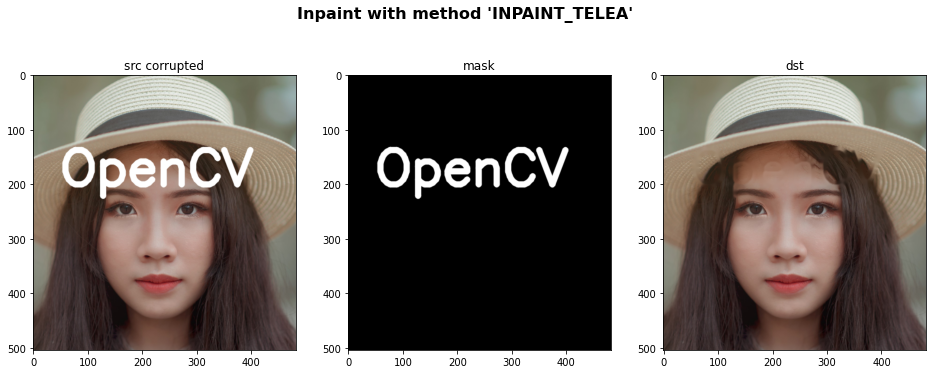

In [198]:
# Create the dimensions of the figure and set title:
plt.figure(figsize=(16, 6))
plt.suptitle("Inpaint with method 'INPAINT_TELEA'", fontsize=16, fontweight='bold')

# Show all the images:
show_img_with_matplotlib(src_corrupted, "src corrupted", 1)
show_img_with_matplotlib(cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR), "mask", 2)
show_img_with_matplotlib(dst_1, "dst", 3)

# Show the figure:
plt.show()

In [199]:
import cv2

font = cv2.FONT_HERSHEY_SIMPLEX

# Loading src image
src_img = cv2.imread('/content/face_test.png')
print("Loaded image with shape: '{}'".format(src_img.shape))

# Creating the mask (same size as the input image):
mask = np.zeros((src_img.shape[0], src_img.shape[1]), dtype="uint8")
print("Mask initialization with shape: '{}'".format(mask.shape))

corrupted_level = 10
mask_size = 10

# We 'corrput' the image writting some text and also create the mask:
src_corrupted = src_img.copy()
cv2.putText(src_corrupted, 'OpenCV', (50, 200), font, 3, (255,255,255), corrupted_level, cv2.LINE_AA)
cv2.putText(mask, 'OpenCV', (50, 200), font, 3, (255,255,255), mask_size, cv2.LINE_AA)
dst_2 = cv2.inpaint(src_corrupted, mask, 3, cv2.INPAINT_NS)

Loaded image with shape: '(504, 482, 3)'
Mask initialization with shape: '(504, 482)'


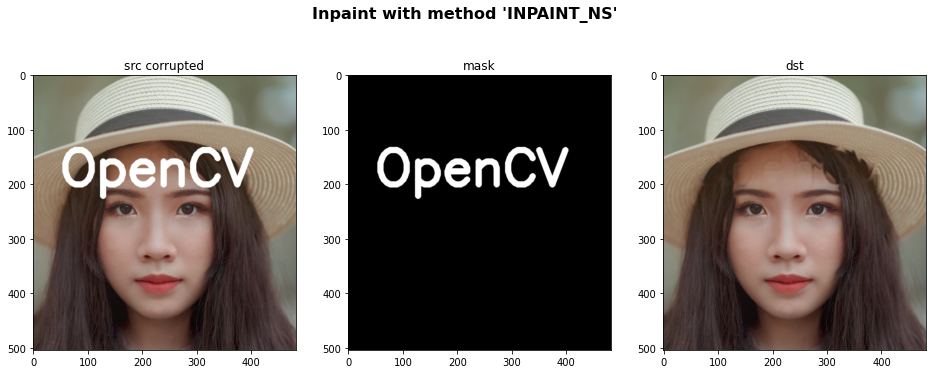

In [142]:
# Create the dimensions of the figure and set title:
plt.figure(figsize=(16, 6))
plt.suptitle("Inpaint with method 'INPAINT_NS'", fontsize=16, fontweight='bold')

# Show all the images:
show_img_with_matplotlib(src_corrupted, "src corrupted", 1)
show_img_with_matplotlib(cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR), "mask", 2)
show_img_with_matplotlib(dst_2, "dst", 3)

# Show the figure:
plt.show()

# Interactive inpainting

In **notebook opencv_sliders_introduction_image_processing.ipynb** we have introduced sliders, which is a nice way of modifying the parameters used by a function in an interactive way. In this section, we are going to modify previous code to incorporate the functionallity provided by the sliders. See next how to do it.

In [177]:
from matplotlib import pyplot as plt


def show_img_with_matplotlib(color_img, title, pos):
    """Shows an image using matplotlib capabilities"""

    # Convert BGR image to RGB
    img_RGB = color_img[:, :, ::-1]

    ax = plt.subplot(1, 2, pos)
    plt.imshow(img_RGB)
    plt.title(title)
    # plt.axis('off')

In [148]:
import cv2

# Loading src image
src_image = cv2.imread('/content/face_test.png')
print("Loaded image with shape: '{}'".format(src_image.shape))

# Creating the mask (same size as the input image):
mask = np.zeros((src_image.shape[0], src_image.shape[1]), dtype="uint8")
print("Mask initialization with shape: '{}'".format(mask.shape))

Loaded image with shape: '(504, 482, 3)'
Mask initialization with shape: '(504, 482)'


In [178]:
font = cv2.FONT_HERSHEY_SIMPLEX

def process_image(src_img, mask_img, corr_val, radius, flag):
  src_corrupted = src_img.copy()
  mask_updated = mask_img.copy()
  cv2.putText(src_corrupted, 'OpenCV', (50, 200), font, 3, (255,255,255), corr_val, cv2.LINE_AA)
  cv2.putText(mask_updated, 'OpenCV', (50, 200), font, 3, (255,255,255), corr_val, cv2.LINE_AA)
  res = cv2.inpaint(src_corrupted, mask_updated, radius, flag)
  return res, mask_updated

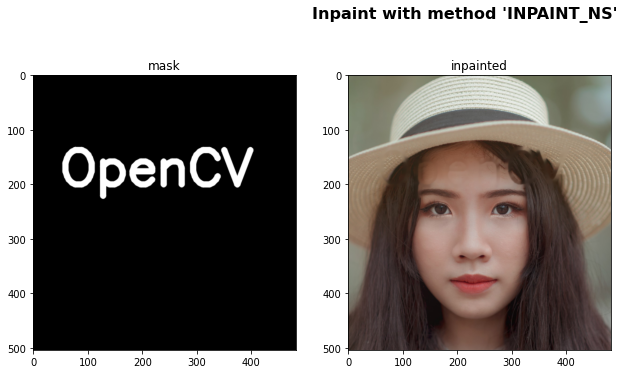

In [200]:
#@title Inpainting { run: "auto" }
corr_value = 5 #@param {type:"slider", min:1, max:30, step:1}
radius=3 #@param {type:"slider", min:1, max:30, step:1}

res, mask_res = process_image(src_image, mask, corr_value, radius, cv2.INPAINT_NS)

# Create the dimensions of the figure and set title:
plt.figure(figsize=(16, 6))
plt.suptitle("Inpaint with method 'INPAINT_NS'", fontsize=16, fontweight='bold')

show_img_with_matplotlib(cv2.cvtColor(mask_res,cv2.COLOR_GRAY2BGR), "mask", 1)
show_img_with_matplotlib(res, "inpainted", 2)

plt.show()

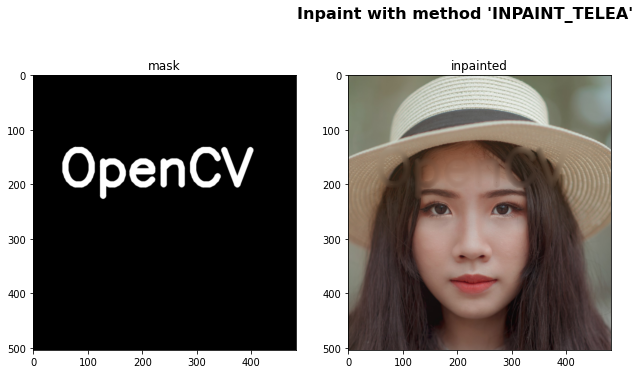

In [201]:
#@title Inpainting { run: "auto" }
corr_value = 5 #@param {type:"slider", min:1, max:30, step:1}
radius=3 #@param {type:"slider", min:1, max:30, step:1}

res, mask_res = process_image(src_image, mask, corr_value, radius, cv2.INPAINT_TELEA)

# Create the dimensions of the figure and set title:
plt.figure(figsize=(16, 6))
plt.suptitle("Inpaint with method 'INPAINT_TELEA'", fontsize=16, fontweight='bold')

show_img_with_matplotlib(cv2.cvtColor(mask_res,cv2.COLOR_GRAY2BGR), "mask", 1)
show_img_with_matplotlib(res, "inpainted", 2)

plt.show()

# Conclusions
In this notebook, we have seen how to apply inpainting, which can be used for image restoration. It is a very popular method and you can find many tutorials showing how to use `cv2.inpaint()` in OpenCV. For example, the OpenCV documentation [provides a nice example](https://docs.opencv.org/master/df/d3d/tutorial_py_inpainting.html).